In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import inspect



# 4. 创建图表
plt.rcParams.update({
    'font.size': 16,          # 全局默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 16,    # x轴刻度字体大小
    'ytick.labelsize': 16,    # y轴刻度字体大小
    'legend.fontsize': 14,     # 图例字体大小

    "font.family": "Arial",       
    "axes.linewidth": 1.5,        
    "xtick.direction": "out",     
    "ytick.direction": "out",
})

In [41]:

from scipy.optimize import curve_fit

import inspect
def count2gamma(df):
    """
    该函数用于将 PMT 计数数据转换为 gamma 值、gamma 误差和相位值。

    参数:
    df (pandas.DataFrame): 包含 PMT 计数数据的 DataFrame，应包含 'pmt1'、'pmt2' 和 'turn' 列。

    返回:
    pandas.DataFrame: 包含计算后的 'gamma'、'gamma_err' 和 'phase' 列的 DataFrame。
    """
    # 计算 gamma 值，公式为 (pmt1 - pmt2) / (pmt1 + pmt2)
    df['gamma']=(df['pmt1']-df['pmt2'])/(df['pmt1']+df['pmt2'])
    # 计算 gamma 误差的平方，公式为 (2 * pmt2 / ((pmt1 + pmt2) ** 2) * sqrt(pmt1)) ** 2 + (-2 * pmt1 / ((pmt1 + pmt2) ** 2) * sqrt(pmt2)) ** 2
    df['gamma_err']=(2*df['pmt2']/((df['pmt1']+df['pmt2'])**2)*np.sqrt(df['pmt1']))**2+(-2*df['pmt1']/((df['pmt1']+df['pmt2'])**2)*np.sqrt(df['pmt2']))**2
    # 对 gamma 误差的平方取平方根，得到 gamma 误差
    df['gamma_err']=np.sqrt(df['gamma_err'])
    # 计算相位值，公式为 turn * 360 * 2
    df['phase']=df['turn']*360*2
# 定义模型函数：正弦波
def model_func_count_offset(x, gamma, phase_offset,count_offset):
    """
    A sin(x + phi) + B
    """
    scale=1
    return gamma*(np.sin(scale*x/180*np.pi + phase_offset))+count_offset

def model_func_sin(x, gamma, phase_offset):
    """
    A sin(x + phi)
    """
    scale=1
    return gamma*(np.sin(scale*x/180*np.pi + phase_offset))



# 生成数据点
def estimate_gamma(df,model_func=model_func_count_offset):
    """  A cos(df + B)
    return estimate [A,B]"""
    x_data = df['turn']*360*2  # x轴数据
    y_data = df['gamma']  # y轴数据
    y_err = df['gamma_err']  # y轴数据误差
    pmt1 = df['pmt1']
    pmt2 = df['pmt2']
    x_data_arange = np.linspace(0, 360*2, 200)  # 生成更多数据点用于拟合
    # 使用curve_fit进行非线性最小二乘法拟合
    # 定义参数的下界和上界
    # 获取函数的参数信息
    sig = inspect.signature(model_func)
    # 获取参数的数量
    param_count = len(sig.parameters)
    if param_count == 2+1:
        lower_bounds = [0, 0]  # 参数 a 和 b 的下界
        upper_bounds = [1, 2*np.pi]  # 参数 a 和 b 的上界
        params, covariance = curve_fit(model_func, x_data, y_data,bounds=(lower_bounds, upper_bounds),sigma=y_err)
    elif param_count == 3+1:
        lower_bounds = [0, 0,-0.1]  # 参数 a 和 b 的下界
        upper_bounds = [1, 2*np.pi,0.2]  # 参数 a 和 b 的上界
        params, covariance = curve_fit(model_func, x_data, y_data,bounds=(lower_bounds, upper_bounds),sigma=y_err)
    else:
        print('model_func has {} parameters, but only 2 or 3 parameters are supported'.format(param_count))
        params, covariance = curve_fit(model_func, x_data, y_data,sigma=y_err)

    # 使用拟合参数计算预测值
    y_pred = model_func(x_data, *params)

    # 计算R²
    mean_y = np.mean(y_data)
    total_variance = np.sum((y_data - mean_y) ** 2)
    residual_variance = np.sum((y_data - y_pred) ** 2)
    r_squared = 1 - (residual_variance / total_variance)
    # 输出拟合参数
    if param_count == 2+1:
        print(f"Fitted parameters: gamma={params[0]:.3f}±{np.sqrt(np.diag(covariance))[0]:.3f}, phase_offset={params[1]:.3f}±{np.sqrt(np.diag(covariance))[1]:.3f}, R²={r_squared:.3%}")
    elif param_count == 3+1:
        print(f"Fitted parameters: gamma={params[0]:.3f}±{np.sqrt(np.diag(covariance))[0]:.3f}, phase_offset={params[1]:.3f}±{np.sqrt(np.diag(covariance))[1]:.3f}, count_offset={params[2]:.3f}±{np.sqrt(np.diag(covariance))[2]:.3f}, R²={r_squared:.3%}")

    # 绘制原始数据点和拟合曲线
    plt.subplot(211)
    plt.errorbar(x_data,pmt1,fmt='-o',yerr=np.sqrt(pmt1),label='pmt1',capsize=5)
    plt.errorbar(x_data,pmt2,fmt='-o',yerr=np.sqrt(pmt2),label='pmt2',capsize=5)
    plt.plot(x_data,(pmt1+pmt2)/2, 'x-.', label='(pmt1+pmt2)/2')
    plt.xlim(0,360*2)
    plt.xlabel('phase offset with 729 OAM turn [°]')
    plt.ylabel('pmt counts')
    plt.title('PMT count, experimental error estimate by shot noise')
    plt.legend(loc=1)
    plt.grid()
    plt.subplot(212)
    plt.errorbar(x_data, (y_data), fmt='o', label='experimental data',yerr=y_err,capsize=5)
    plt.plot(x_data_arange,(model_func(x_data_arange, *params)), '-', label='fit {:.1%}±{:.1%}'.format(np.abs(params[0]),np.sqrt(np.diag(covariance))[0]))
    plt.xlabel('phase offset with 729 OAM turn [°] {:+.2f}°'.format(params[1]/np.pi*180))
    plt.ylabel('estimae gamma')
    plt.title('LS estimae $\\gamma$: {:.3%}±{:.3%}, $R^2=${:.1%}'.format(np.abs(params[0]),np.sqrt(np.diag(covariance))[0],r_squared))
    plt.xlim(0,360*2)
    plt.legend(loc=1)
    plt.grid()
    plt.tight_layout()
    params_err=np.sqrt(np.diag(covariance))

    return params,params_err


-------------origin data-----------------
Fitted parameters: gamma=0.980±0.003, phase_offset=3.193±0.011, count_offset=-0.005±0.003, R²=99.967%


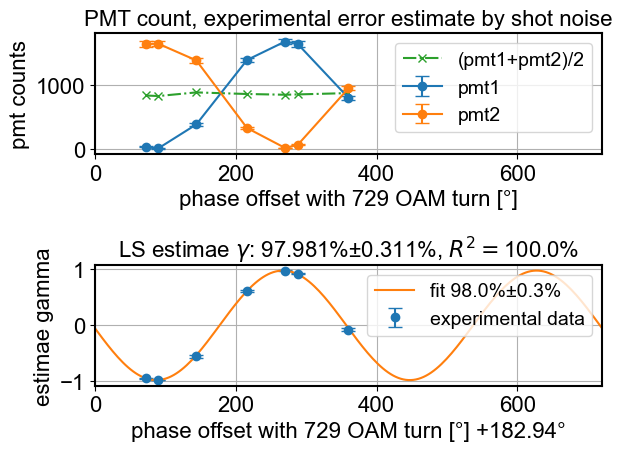

In [42]:
out_csv='../251022_fig/10km/gamma_res_time.csv'
res_data=pd.read_csv(out_csv)
count2gamma(res_data)
res_data.sort_values(by='turn',inplace=True)
origin_df=res_data[res_data['state']=='origin']
monitor_df=res_data[res_data['state']=='monitor']
print('-------------origin data-----------------')
param_origin,param_origin_err=estimate_gamma(origin_df,model_func=model_func_count_offset)
plt.show()
phase_array=np.linspace(-180,360*2,500)
turn_array=phase_array/360/2
origin_fit=model_func_count_offset(phase_array,*param_origin)

In [43]:
vis_df = pd.read_csv('vis_ion.csv')
_parity_index=(vis_df['parity']>0)
_visbility_index=(vis_df['distance']>0)

VIS_HIGHLINE=vis_df.loc[0,'visibility']
VISHIGHLINE_ERR=vis_df.loc[0,'vis_err']



c0,c1,c2,c3,c4="#d9042b","#730220","#03658c","#f29f05","#f27b50"

/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_77326/3707278575.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


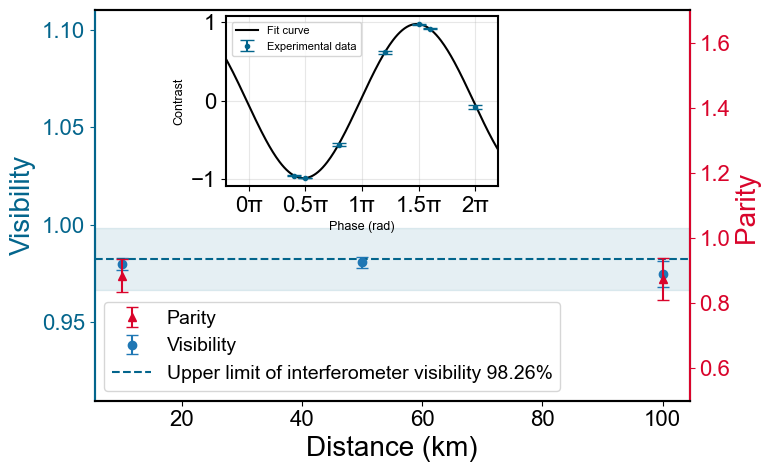

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as patches

# 4. 创建图表
fig, ax1 = plt.subplots(figsize=(8,5),dpi=100)
ax2=ax1.twinx()

# 绘制数据并保存返回值以获取句柄
vis_line = ax1.errorbar(vis_df['distance'][_visbility_index],vis_df['visibility'][_visbility_index],fmt='o',yerr=vis_df['vis_err'][_visbility_index],capsize=4,label='Visibility')
ion_line = ax2.errorbar(vis_df['distance'][_parity_index],vis_df['parity'][_parity_index],fmt='^',color=c0,yerr=vis_df['parity_err'][_parity_index],capsize=4,label='Parity')
## 绘制上限区域
## 绘制上限区域
limit_line = ax1.axhline(VIS_HIGHLINE,ls='--',color=c2,label='Upper limit of interferometer visibility {:.2%}'.format(VIS_HIGHLINE))
## 区域用渐变色填充
limit_line_err = ax1.axhspan(VIS_HIGHLINE-VISHIGHLINE_ERR, VIS_HIGHLINE+VISHIGHLINE_ERR, color=c2, alpha=0.1)

# 设置轴的颜色
ax1.tick_params(axis='y', colors=c2)
ax2.tick_params(axis='y', colors=c0)
ax1.spines['left'].set_color(c2)
ax2.spines['left'].set_color(c2)
ax2.spines['right'].set_color(c0)

# 设置轴标签和范围
ax1.set_xlabel('Distance (km)',fontsize=20)
ax1.set_ylabel('Visibility',color=c2,fontsize=20)
ax1.set_ylim(0.9+0.01,1.1+0.01)
ax2.set_ylabel('Parity ',color=c0, fontsize=20)
ax2.set_ylim(0.5,1.7)
# 合并所有图例
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines = [h for handles, labels in lines_labels for h in handles]
labels = [l for handles, labels in lines_labels for l in labels]
ax1.legend(lines[::-1], labels[::-1],loc='lower left')  # 可以根据需要调整位置

# 5. 创建嵌入图（副图）
ax_inset = fig.add_axes([0.3, 0.6, 0.34, 0.34])  # [left, bottom, width, height]

# 绘制副图：时间符合直方图
ax_inset.plot(turn_array*4,origin_fit,label='Fit curve',color='k')
ax_inset.errorbar(origin_df['turn']*4,origin_df['gamma'],yerr=origin_df['gamma_err'],fmt='.',capsize=5,
             label='Experimental data',color=c2)

# 设置副图坐标轴（对数纵坐标）
ax_inset.set_xlabel(' (ns)', fontsize=9)
ax_inset.set_ylabel('', fontsize=9)
ax_inset.legend(fontsize=8)
ax_inset.grid(True, alpha=0.3)
ax_inset.set_xlabel('Phase (rad)', fontsize=9)
ax_inset.set_xlim(-0.2,2+0.2)
# 设置x轴刻度为π的倍数并添加π符号
ticks = np.arange(0, 2+0.2, 1/2)
labels = ['0π', '0.5π', '1π', '1.5π', '2π']
ax_inset.set_xticks(ticks)
ax_inset.set_xticklabels(labels)
ax_inset.set_ylabel('Contrast')
# 6. 美化图表
plt.tight_layout()
plt.savefig('FIG3_exp_result.pdf', dpi=500)
plt.show()

# 7. 可选：保存图表

/var/folders/nx/zj1vqp1j21524rfk5s8nbb9h0000gn/T/ipykernel_77326/3214206685.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


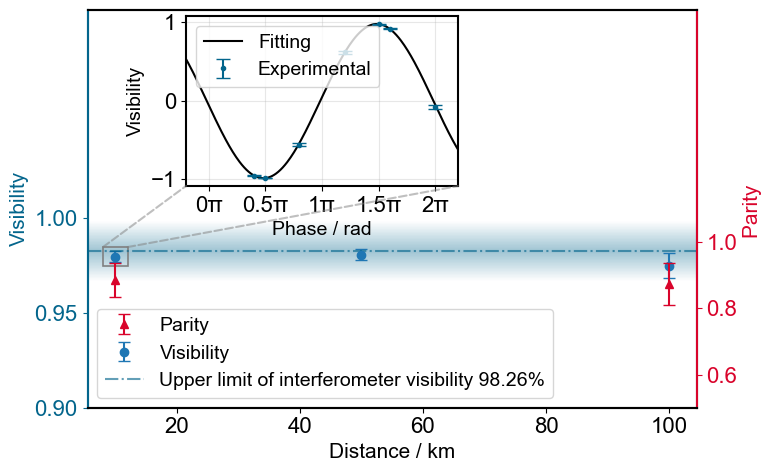

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as patches



fig, ax1 = plt.subplots(figsize=(8,5),dpi=100)
ax2=ax1.twinx()

# 绘制数据并保存返回值以获取句柄
vis_line = ax1.errorbar(vis_df['distance'][_visbility_index],vis_df['visibility'][_visbility_index],fmt='o',yerr=vis_df['vis_err'][_visbility_index],capsize=4,label='Visibility')
ion_line = ax2.errorbar(vis_df['distance'][_parity_index],vis_df['parity'][_parity_index],fmt='^',color=c0,yerr=vis_df['parity_err'][_parity_index],capsize=4,label='Parity')
## 绘制上限区域
limit_line = ax1.axhline(VIS_HIGHLINE,ls='-.',color=c2,label='Upper limit of interferometer visibility {:.2%}'.format(VIS_HIGHLINE),alpha=0.618)

## 区域用渐变色填充 - 从中间向两边渐变
# 获取当前轴的x轴范围
x_min, x_max = ax1.get_xlim()

# 创建渐变填充
y_low = VIS_HIGHLINE - VISHIGHLINE_ERR
y_high = VIS_HIGHLINE + VISHIGHLINE_ERR
n_bins = 100  # 使用的颜色数量

# 确保c2是正确的颜色格式
if isinstance(c2, str):
    # 如果c2是颜色名称，使用matplotlib的颜色转换器
    from matplotlib.colors import to_rgba
    base_color = to_rgba(c2)
else:
    base_color = c2

# 从中间向两边渐变（水平方向）
# 确定中间点
x_mid = (x_min + x_max) / 2

# 使用多个矩形补丁来创建渐变效果
for i in range(n_bins):
    # 计算当前矩形的y坐标范围（垂直渐变）
    y_start = y_low + (y_high - y_low) * i / n_bins
    y_end = y_low + (y_high - y_low) * (i + 1) / n_bins
    if i > n_bins/2:
        i-=n_bins/2
        # 透明度从高到低
        alpha = 0.381 - (0.381 * i / n_bins*2)  # 从0.7到0.0的透明度渐变
    else:
        # 透明度从低到高（或从高到低）
        alpha = 0.0 + (0.381 * i / n_bins*2)  # 从0.0到0.7的透明度渐变
    
    # 创建矩形补丁
    rect = patches.Rectangle((x_min, y_start), x_max - x_min, y_end - y_start,
                             facecolor=base_color, alpha=alpha, edgecolor='none', zorder=0)
    ax1.add_patch(rect)


# 重置x轴范围（因为添加补丁可能会改变它）
ax1.set_xlim(x_min, x_max)

# 设置轴的颜色
ax1.tick_params(axis='y', colors=c2)
ax2.tick_params(axis='y', colors=c0)
ax1.spines['left'].set_color(c2)
ax2.spines['left'].set_color(c2)
ax2.spines['right'].set_color(c0)

# 设置轴标签和范围
ax1.set_xlabel('Distance / km', fontsize=15)
ax1.set_ylabel('Visibility',color=c2, fontsize=15)
ax1.set_ylim(0.9+0.01,1.1+0.01)
ax2.set_ylabel('Parity ',color=c0, fontsize=15)
ax2.set_ylim(0.5,1.7)

# 自定义ax1轴的刻度标签 - 只显示小于1的刻度，大于1的不显示
# 获取当前刻度值
yticks1 = ax1.get_yticks()
# 创建新的刻度标签列表，小于1的显示原值，大于1的设为空字符串
new_labels1 = [str(tick) if tick < 1 else '' for tick in yticks1]
# 创建新的刻度列表，只保留小于1的刻度位置
new_ticks1 = [tick for tick in yticks1 if tick <= 1]
# 应用新的刻度和标签
ax1.set_yticks(new_ticks1)

# 自定义ax2轴的刻度标签 - 显示0.825~0.925范围内的刻度
# 获取当前刻度值
yticks2 = ax2.get_yticks()
# 创建新的刻度标签列表，在0.825~0.925范围内的显示原值，否则设为空字符串
new_labels2 = [str(tick) if 0.825 <= tick <= 0.925 else '' for tick in yticks2]
# 创建新的刻度列表，只保留0.825~0.925范围内的刻度位置
new_ticks2 = [tick for tick in yticks2 if 0.5<= tick <= 1]
# 应用新的刻度和标签
ax2.set_yticks(new_ticks2)

# 用红色方框圈出visibility散点图的第二个点
# 获取第二个点的坐标（索引为1）
second_point_x = vis_df['distance'][_visbility_index][1]
second_point_y = vis_df['visibility'][_visbility_index][1]

# 设置方框大小（根据数据范围调整）
box_width = 4  # 可以根据实际数据范围调整
box_height = 0.01  # 可以根据实际数据范围调整

# 创建红色方框
red_box = patches.Rectangle((second_point_x - box_width/2, second_point_y - box_height/2), 
                           box_width, box_height, edgecolor='gray', facecolor='none', linewidth=1.2)
ax1.add_patch(red_box)

# 合并所有图例
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines = [h for handles, labels in lines_labels for h in handles]
labels = [l for handles, labels in lines_labels for l in labels]
ax1.legend(lines[::-1], labels[::-1],loc='lower left')  # 可以根据需要调整位置

# 5. 创建嵌入图（副图）
ax_inset = fig.add_axes([0.25, 0.6, 0.34, 0.34])  # [left, bottom, width, height]

# 绘制副图：时间符合直方图
ax_inset.plot(turn_array*4,origin_fit,label='Fitting',color='k')
ax_inset.errorbar(origin_df['turn']*4,origin_df['gamma'],yerr=origin_df['gamma_err'],fmt='.',capsize=5,
             label='Experimental',color=c2)

# 设置副图坐标轴（对数纵坐标）
ax_inset.set_xlabel(' (ns)', fontsize=14)
ax_inset.set_ylabel('', fontsize=14)
ax_inset.legend(fontsize=14,loc='upper left')
ax_inset.grid(True, alpha=0.3)
ax_inset.set_xlabel('Phase / rad', fontsize=14)
ax_inset.set_xlim(-0.2,2+0.2)
# 设置x轴刻度为π的倍数并添加π符号
ticks = np.arange(0, 2+0.2, 1/2)
labels = ['0π', '0.5π', '1π', '1.5π', '2π']
ax_inset.set_xticks(ticks)
ax_inset.set_xticklabels(labels)
ax_inset.set_ylabel('Visibility')

# 添加灰色虚线连接主图中的红色方框和子图，表示子图是该区域的放大
# 使用更可靠的方法创建连接线
# 从红色方框中心到子图左下角和右下角
# 创建两条灰色虚线连接

# 从方框到子图的两条连接线
# 使用ConnectionPatch的正确参数
con1 = patches.ConnectionPatch(
    xyA=(second_point_x-box_width/2, second_point_y + box_height/2),  # 主图中红色方框上边缘中点
    xyB=(0, 0),  # 子图的左上角（归一化坐标）
    coordsA="data",  # 主图使用数据坐标
    coordsB="axes fraction",  # 子图使用归一化坐标
    axesA=ax1,  # 主图坐标轴
    axesB=ax_inset,  # 子图坐标轴
    linestyle='--',
    color='gray',
    alpha=0.5,
    linewidth=1.5
)

con2 = patches.ConnectionPatch(
    xyA=(second_point_x+box_width/2, second_point_y + box_height/2),  # 主图中红色方框上边缘中点
    xyB=(1, 0),  # 子图的右上角（归一化坐标）
    coordsA="data",  # 主图使用数据坐标
    coordsB="axes fraction",  # 子图使用归一化坐标
    axesA=ax1,  # 主图坐标轴
    axesB=ax_inset,  # 子图坐标轴
    linestyle='--',
    color='gray',
    alpha=0.5,
    linewidth=1.5
)

# 添加连接线到图形
fig.add_artist(con1)
fig.add_artist(con2)

# 6. 美化图表
plt.tight_layout()
plt.savefig('Fig3_exp_result.pdf', dpi=1000,bbox_inches='tight')
plt.show()

已将两个PDF整合为一个ab图并保存到 Fig3_result.pdf


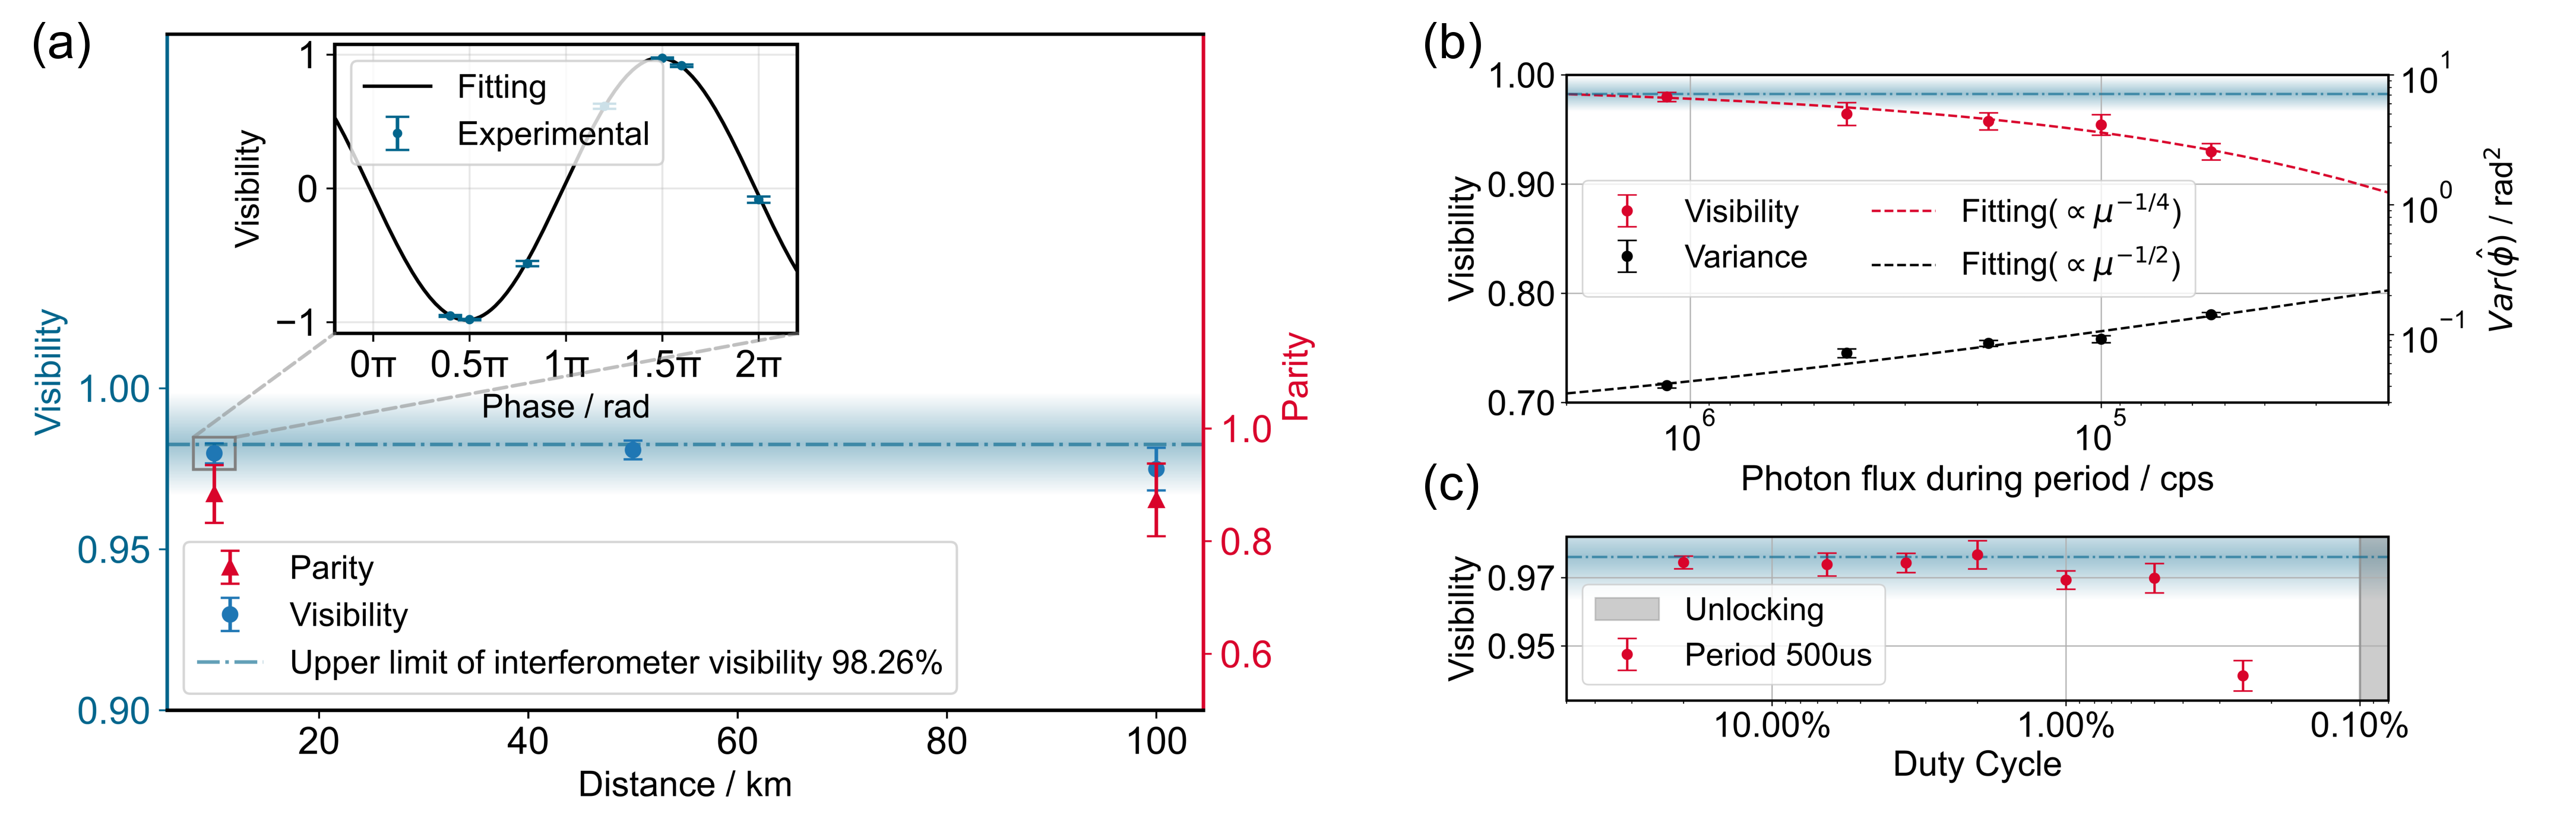

In [55]:
# 读取两个 pdf 整合为一个ab 图
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import os
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
poplar_path= '/opt/homebrew/Cellar/poppler/25.10.0/bin'
## 添加到系统变量
os.environ['PATH'] += os.pathsep + poplar_path


# 两个PDF文件路径
pdf_file1 = 'Fig3_exp_result.pdf'
pdf_file2 = 'SM/dutycycle_cps_vis_65us_2.pdf'

# 检查文件是否存在
if not os.path.exists(pdf_file1):
    print(f"警告: 文件 {pdf_file1} 不存在")
if not os.path.exists(pdf_file2):
    print(f"警告: 文件 {pdf_file2} 不存在")

# 将PDF转换为图像
try:
    # 只获取第一页
    images1 = convert_from_path(pdf_file1, dpi=1000, first_page=1, last_page=1)
    images2 = convert_from_path(pdf_file2, dpi=1000, first_page=1, last_page=1)
    
    # 创建一个新的图形，分为a和b两个子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=300)
    
    # 在a子图中显示第一个PDF的内容
    ax1.imshow(images1[0])
    ax1.axis('off')  # 隐藏坐标轴
    
    # 在b子图中显示第二个PDF的内容
    ax2.imshow(images2[0])
    ax2.axis('off')  # 隐藏坐标轴
    
    # 添加a)和b)标签
    ax1.text(0.01, 0.95, '(a)', transform=ax1.transAxes, fontsize=20)
    ax2.text(0.01, 0.95, '(b)', transform=ax2.transAxes, fontsize=20)
    ax2.text(0.01, 0.4, '(c)', transform=ax2.transAxes, fontsize=20)
    
    # 调整子图之间的间距# 调整子图之间的间距
    plt.tight_layout()
    # 减小子图之间的水平间距
    plt.subplots_adjust(wspace=-0.1)  # 可以根据需要调整这个值，0表示没有间距

    
    # 保存为新的PDF文件
    output_file = 'Fig3_result.pdf'
    plt.savefig(output_file, bbox_inches='tight')
    print(f"已将两个PDF整合为一个ab图并保存到 {output_file}")
    # 显示图形
    plt.show()
    
except Exception as e:
    print(f"处理PDF时出错: {e}")
    print("请确保已安装pdf2image和poppler-utils")
    print("安装命令: pip install pdf2image")
    print("对于macOS: brew install poppler")
    print("对于Ubuntu/Debian: apt-get install poppler-utils")